# Problem Statement

Estimasi waktu pengiriman yang tidak akurat sering kali menyebabkan menurunnya kepuasan pelanggan dan inefisiensi alokasi kurir. Perusahaan perlu mengetahui faktor apa saja yang paling memengaruhi durasi pengiriman dan bagaimana cara memprediksinya secara tepat untuk mengatasi tantangan operasional ini.

# Business Objective

Tujuan dari proyek ini adalah:

* Membangun Model Prediksi: Mengembangkan model machine learning dengan performa tinggi untuk estimasi waktu pengiriman.
* Mengidentifikasi Faktor Kunci: Menganalisis dan menentukan variabel paling signifikan yang memengaruhi waktu tempuh pengiriman.
* Memberikan Rekomendasi Bisnis: Menyediakan insight yang dapat ditindaklanjuti untuk optimisasi rute, alokasi sumber daya, dan peningkatan layanan pelanggan.

    
Manfaat Bisnis: Meningkatkan kepuasan dan kepercayaan pelanggan dengan memberikan ekspektasi yang lebih realistis, mengurangi jumlah keluhan terkait keterlambatan.

# Data Understanding

[Dataset](https://www.kaggle.com/datasets/denkuznetz/food-delivery-time-prediction) ini, berfokus pada prediksi waktu pengiriman berdasarkan faktor-faktor seperti jarak, cuaca, kondisi lalu lintas, waktu, jenis kendaraan, waktu persiapan, dan pengalaman kurir.

**Dataset column description:**

**Order_ID:** ID pesanan unik untuk setiap pesanan.

**Distance_km:** Jarak pengiriman dalam satuan kilometer.

**Weather:** Kondisi cuaca selama pengiriman, meliputi Cerah (Clear), Hujan (Rainy), Bersalju (Snowy), Berkabut (Foggy), dan Berangin (Windy).

**Traffic_Level:** Kondisi lalu lintas yang dikategorikan sebagai Rendah (Low), Sedang (Medium), atau Tinggi (High).

**Time_of_Day:** Waktu saat pengiriman dilakukan, dikategorikan sebagai Pagi (Morning), Siang (Afternoon), Sore (Evening), atau Malam (Night).

**Vehicle_Type:** Jenis kendaraan yang digunakan untuk pengiriman, termasuk Sepeda (Bike), Skuter (Scooter), dan Mobil (Car).

**Preparation_Time_min:** Waktu yang diperlukan untuk menyiapkan pesanan, diukur dalam menit.

**Courier_Experience_yrs:** Pengalaman kurir dalam tahun.

**Delivery_Time_min:** Total waktu pengiriman dalam menit (variabel target).

# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read csv
df = pd.read_csv('https://drive.google.com/uc?id=1zKCu5hff1oEIYWPfgzPHLY8S1Afdm024')

In [3]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [4]:
for col in ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']:
    print(f"\nUnique values in {col}:")
    print(df[col].dropna().unique())


Unique values in Weather:
['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']

Unique values in Traffic_Level:
['Low' 'Medium' 'High']

Unique values in Time_of_Day:
['Afternoon' 'Evening' 'Night' 'Morning']

Unique values in Vehicle_Type:
['Scooter' 'Bike' 'Car']


# Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [6]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [7]:
# Cek missing value pada dataset
print("Missing values pada setiap kolom:")
print(df.isnull().sum())

Missing values pada setiap kolom:
Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64


In [8]:
# Cek data duplikat
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


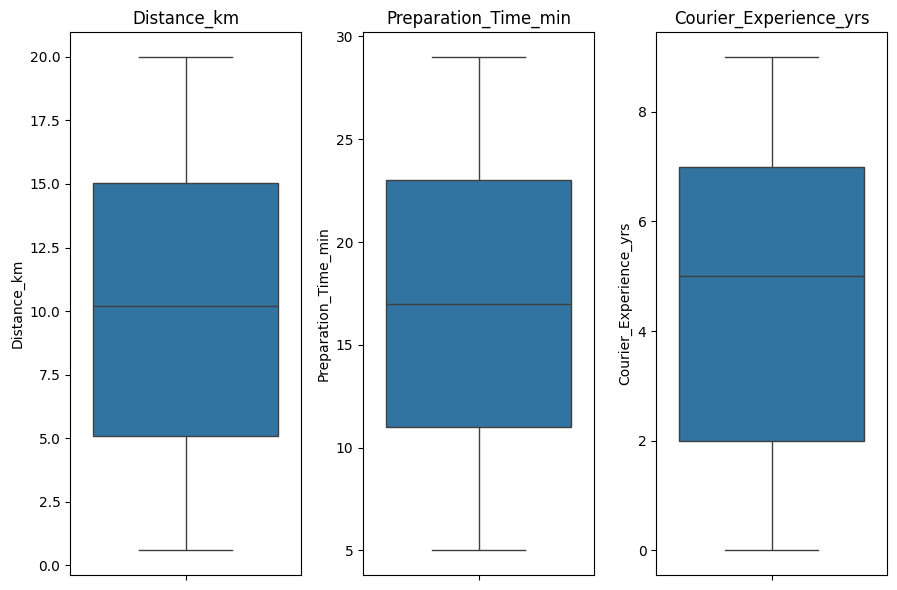

In [9]:
# Cek outlier
numerical_cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']

# Visualisasi boxplot
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

**Insight:**
* Terdapat missing value pada kolom Weather, Traffic_Level, Time_of_Day, dan Courier_Experience_yrs masing-masing 30 rows (3%)
* Tidak ada duplicate data
* Tidak ada outlier pada kolom selain target

Missing Value, Outlier dan Data Duplicate handling dilakukan **hanya** pada data latih (train set) setelah split, agar tidak terjadi data leakage. Hal ini untuk menghindari model jadi overfitting dan performa tampak terlalu bagus saat evaluasi.

## Cek Distribusi Target

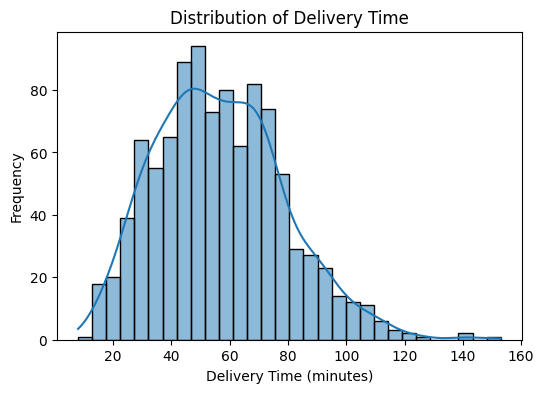

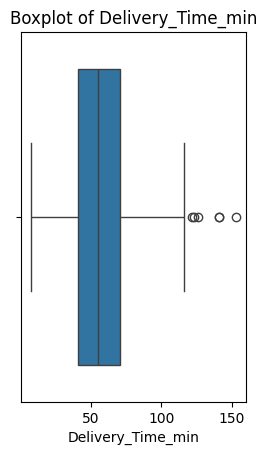

In [10]:
# Histogram
plt.figure(figsize=(6, 4))
sns.histplot(df['Delivery_Time_min'], kde=True, bins=30)
plt.title('Distribution of Delivery Time')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=df['Delivery_Time_min'])
plt.title('Boxplot of Delivery_Time_min')
plt.show()


**Insight:**

Histogram:

* Distribusi tidak normal sempurna — terlihat positively skewed (condong ke kanan).

* Mayoritas waktu pengiriman berada di antara 40–80 menit, dengan puncak sekitar 55–60 menit.

* Terdapat beberapa nilai ekstrem (outliers) di atas 120 menit, bahkan mendekati 160 menit.

Boxplot:

* Median berada di sekitar 60 menit.

* Banyak outlier di sisi atas (high-end outliers), dan tidak ada outlier di sisi bawah.

* Distribusi agak asimetri (right-skewed).

Dengan hasil ini, kita akan tetap mempertahankan kasus ekstrem (outlier) karena penting secara operasional. Dalam permodelan kita akan menggunakan model yang robust terhadap outlier. (ex: Random Forest, XGBoost)

## Korelasi Antar Variabel

### Numerikal v.s Target

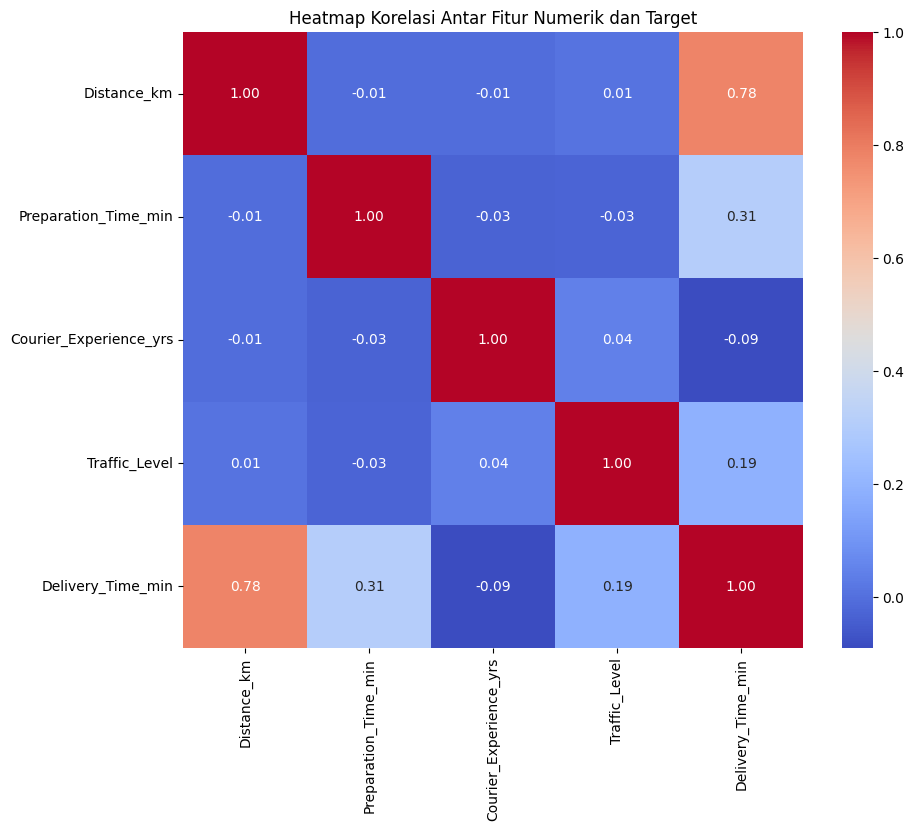

In [11]:
# Korelasi antar fitur numerik dan target
plt.figure(figsize=(10, 8))
# Buat DataFrame baru untuk korelasi dengan fitur ordinal yang sudah di-encode
df_corr = df.copy()
df_corr['Traffic_Level'] = df_corr['Traffic_Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
correlation_matrix = df_corr[numerical_cols + ['Traffic_Level', 'Delivery_Time_min']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Antar Fitur Numerik dan Target')
plt.show()

**Insight:**

Terlihat korelasi positif yang kuat antara Distance_km dan Delivery_Time_min (0.78). Ini menunjukkan jarak adalah prediktor yang sangat penting. Preparation_Time_min (0.31) dan Traffic_Level (0.19) juga memiliki korelasi positif yang cukup kuat.

Notes:

Saya melakukan encoding pada Traffic_Level secara spesifik untuk heatmap korelasi karena:

* Heatmap korelasi hanya bisa bekerja dengan data numerik.

* Karena Traffic_Level adalah ordinal (Low < Medium < High), mengubahnya menjadi angka (0 < 1 < 2 ) memungkinkan kita untuk secara kuantitatif melihat hubungannya dengan variabel numerik lain seperti Delivery_Time_min dalam satu visualisasi. Hasilnya, kita bisa melihat korelasi positif yang menunjukkan bahwa semakin tinggi level lalu lintas, semakin lama waktu pengiriman.

### Kategorikal v.s Target

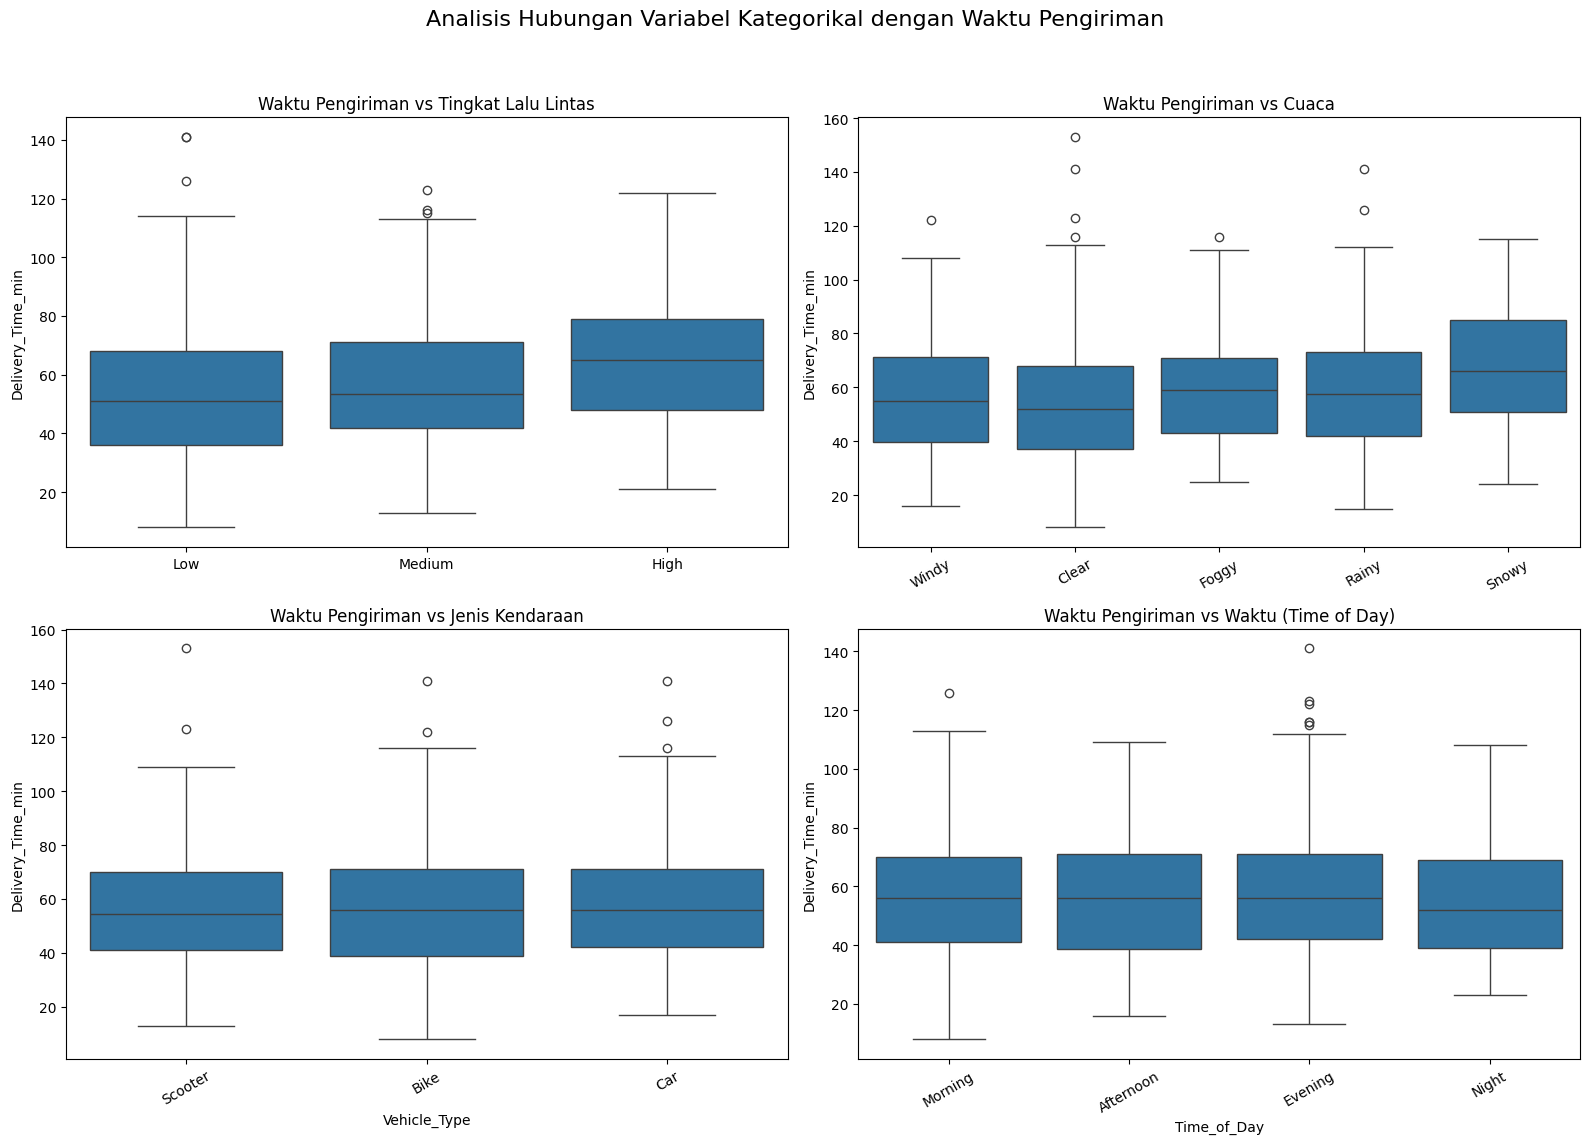

In [12]:
# Mengubah layout menjadi 2 baris x 2 kolom untuk 4 visualisasi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisis Hubungan Variabel Kategorikal dengan Waktu Pengiriman', fontsize=16)

# Plot 1: Traffic Level (posisi: baris 0, kolom 0)
sns.boxplot(ax=axes[0, 0], x='Traffic_Level', y='Delivery_Time_min', data=df, order=['Low', 'Medium', 'High'])
axes[0, 0].set_title('Waktu Pengiriman vs Tingkat Lalu Lintas')
axes[0, 0].set_xlabel('') # Menghilangkan label x untuk kebersihan

# Plot 2: Weather (posisi: baris 0, kolom 1)
sns.boxplot(ax=axes[0, 1], x='Weather', y='Delivery_Time_min', data=df)
axes[0, 1].set_title('Waktu Pengiriman vs Cuaca')
axes[0, 1].tick_params(axis='x', rotation=30)
axes[0, 1].set_xlabel('') # Menghilangkan label x

# Plot 3: Vehicle Type (posisi: baris 1, kolom 0)
sns.boxplot(ax=axes[1, 0], x='Vehicle_Type', y='Delivery_Time_min', data=df)
axes[1, 0].set_title('Waktu Pengiriman vs Jenis Kendaraan')
axes[1, 0].tick_params(axis='x', rotation=30)

# Plot 4: Time of Day (posisi: baris 1, kolom 1)
time_order = ['Morning', 'Afternoon', 'Evening', 'Night'] # Menambahkan urutan logis
sns.boxplot(ax=axes[1, 1], x='Time_of_Day', y='Delivery_Time_min', data=df, order=time_order)
axes[1, 1].set_title('Waktu Pengiriman vs Waktu (Time of Day)')
axes[1, 1].tick_params(axis='x', rotation=30)

# Menyesuaikan layout secara otomatis agar tidak tumpang tindih
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Memberi ruang untuk judul utama
plt.show()

**Insight:**

1. Tingkat Lalu Lintas (Traffic_Level):
  * Hubungan Positif Kuat: Waktu pengiriman meningkat secara signifikan seiring naiknya level lalu lintas dari Low ke High.
  * Faktor Prediktor Utama: Merupakan salah satu faktor paling berpengaruh dalam memprediksi durasi pengiriman.

2. Cuaca (Weather):
  * Cuaca Buruk Memperlambat: Kondisi Snowy (bersalju) menyebabkan waktu pengiriman terlama, diikuti Foggy (berkabut) dan Rainy (hujan).
  * Kondisi Ideal: Waktu pengiriman tercepat terjadi saat cuaca Clear (cerah).

3. Jenis Kendaraan (Vehicle_Type):
  * Tidak Berpengaruh Signifikan: Jenis kendaraan (Scooter, Bike, Car) tidak menunjukkan perbedaan besar terhadap waktu pengiriman.
  * Faktor Lain Lebih Dominan: Jarak dan lalu lintas kemungkinan memiliki pengaruh yang jauh lebih kuat.

4. Waktu Pengiriman (Time_of_Day):
  * Waktu Puncak: Waktu pengiriman cenderung paling lama pada periode Evening (sore/malam), sejalan dengan jam sibuk.
  * Risiko Keterlambatan Tertinggi: Periode Evening memiliki risiko keterlambatan ekstrem (outlier) paling tinggi, menandakan potensi keluhan pelanggan terbesar.
  * Waktu Paling Efisien: Periode Night (tengah malam) menunjukkan waktu pengiriman tercepat dan paling efisien.

## Analisis Faktor yang Mempengaruhi Keterlambatan

In [13]:
# Buat salinan DataFrame agar tidak mengubah DataFrame asli ('df').
# Semua operasi analisis akan dilakukan pada 'df_analysis'.
df_analysis = df.copy()

# Tentukan ambang batas 'telat' menggunakan persentil ke-75 (Q3) dari DataFrame salinan
late_threshold = df_analysis['Delivery_Time_min'].quantile(0.75)

print(f"Berdasarkan data, 25% pengiriman terlama memakan waktu lebih dari {late_threshold:.2f} menit.")
print(f"Kita akan mengklasifikasikan pengiriman di atas waktu ini sebagai 'Telat'.")

# Buat kolom baru 'Is_Late' HANYA di DataFrame salinan ('df_analysis')
df_analysis['Is_Late'] = df_analysis['Delivery_Time_min'] > late_threshold

# Lihat hasilnya dari DataFrame salinan
print("\nJumlah pengiriman berdasarkan status 'Telat' (dari data analisis):")
print(df_analysis['Is_Late'].value_counts())

Berdasarkan data, 25% pengiriman terlama memakan waktu lebih dari 71.00 menit.
Kita akan mengklasifikasikan pengiriman di atas waktu ini sebagai 'Telat'.

Jumlah pengiriman berdasarkan status 'Telat' (dari data analisis):
Is_Late
False    765
True     235
Name: count, dtype: int64


**Insight:** Telat itu relatif. Kita perlu membuat definisi yang berdasarkan data. Cara paling umum dan dapat dipertanggungjawabkan adalah dengan menggunakan persentil. Kita akan menganggap pengiriman yang masuk dalam 25% terlama sebagai "Telat".

### Analisis Keterlambatan berdasarkan: Traffic_Level ###
Probabilitas 'Telat' untuk setiap kategori:
Is_Late           False     True 
Traffic_Level                    
High           0.649746  0.350254
Medium         0.764103  0.235897
Low            0.827676  0.172324


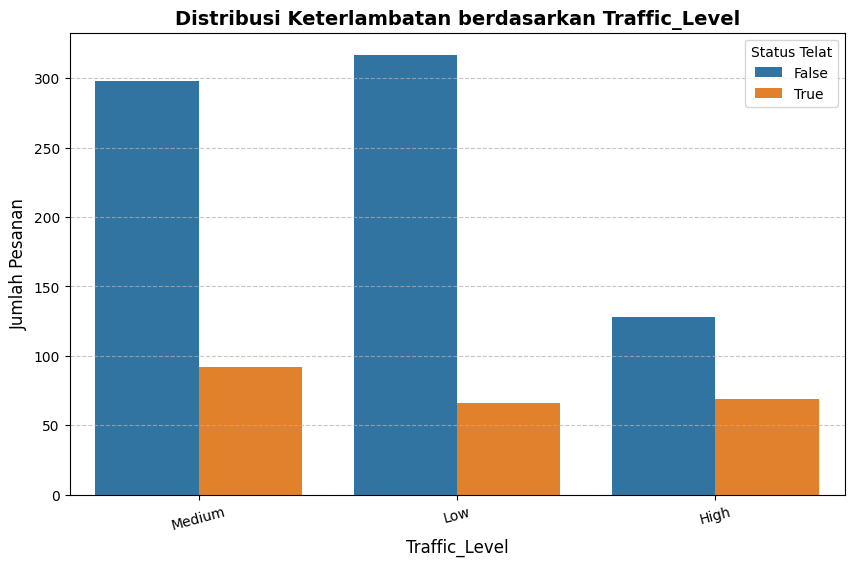

### Analisis Keterlambatan berdasarkan: Weather ###
Probabilitas 'Telat' untuk setiap kategori:
Is_Late     False     True 
Weather                    
Snowy    0.628866  0.371134
Rainy    0.730392  0.269608
Windy    0.750000  0.250000
Foggy    0.757282  0.242718
Clear    0.810638  0.189362


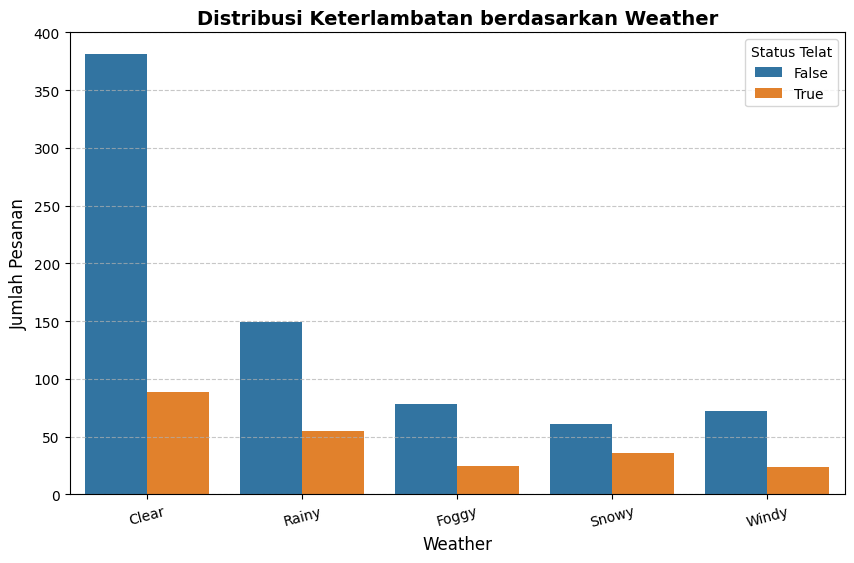

### Analisis Keterlambatan berdasarkan: Time_of_Day ###
Probabilitas 'Telat' untuk setiap kategori:
Is_Late         False     True 
Time_of_Day                    
Evening      0.757679  0.242321
Afternoon    0.760563  0.239437
Morning      0.785714  0.214286
Night        0.788235  0.211765


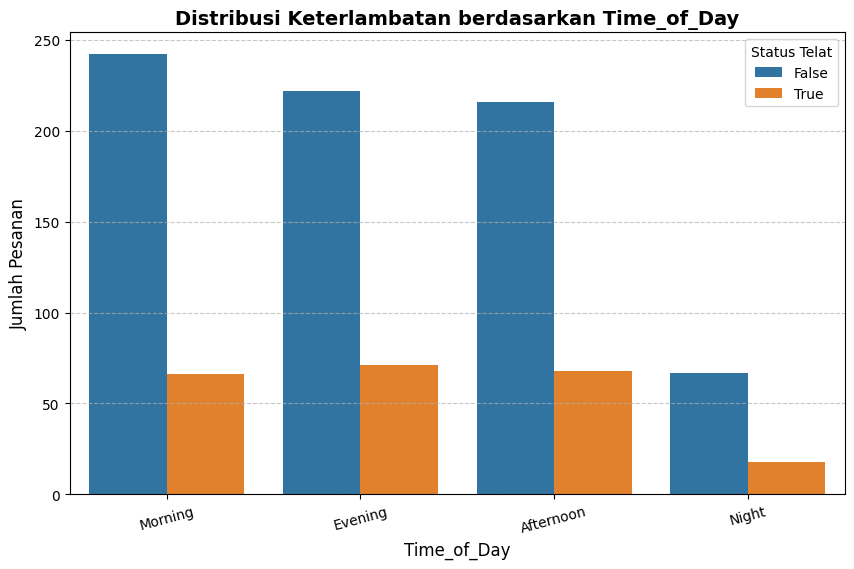

### Analisis Keterlambatan berdasarkan: Vehicle_Type ###
Probabilitas 'Telat' untuk setiap kategori:
Is_Late          False     True 
Vehicle_Type                    
Bike          0.755467  0.244533
Car           0.758974  0.241026
Scooter       0.784768  0.215232


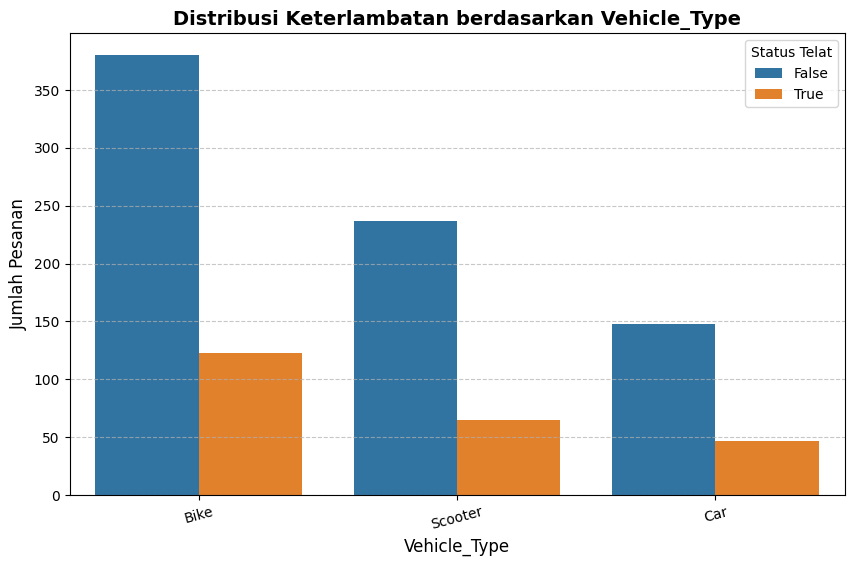

In [14]:
# Daftar fitur kategorikal yang ingin kita analisis
categorical_features_to_analyze = ['Traffic_Level', 'Weather', 'Time_of_Day', 'Vehicle_Type']

# Loop melalui setiap fitur untuk analisis dan visualisasi
for feature in categorical_features_to_analyze:

    print("="*60)
    print(f"### Analisis Keterlambatan berdasarkan: {feature} ###")
    print("="*60)

    # 1. Membuat tabel probabilitas
    analysis_table = pd.crosstab(df_analysis[feature], df_analysis['Is_Late'], normalize='index')

    # Mengurutkan berdasarkan probabilitas 'Telat' (True) dari yang paling berisiko
    analysis_table_sorted = analysis_table.sort_values(by=True, ascending=False)

    print("Probabilitas 'Telat' untuk setiap kategori:")
    print(analysis_table_sorted)

    # 2. Membuat Visualisasi
    plt.figure(figsize=(10, 6))

    # Mengurutkan bar plot berdasarkan frekuensi kategori
    order = df[feature].value_counts().index

    sns.countplot(data=df_analysis, x=feature, hue='Is_Late', order=order)

    plt.title(f'Distribusi Keterlambatan berdasarkan {feature}', fontsize=14, weight='bold')
    plt.ylabel('Jumlah Pesanan', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.xticks(rotation=15) # Rotasi sedikit agar tidak tumpang tindih
    plt.legend(title='Status Telat')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

**Insight:** Probabilitas keterlambatan (kolom True) sangat tinggi untuk Traffic_Level: High (0.350) atau saat Weather: Snowy (0.371) dibanding dengan fitur yang lain (< 0.30).

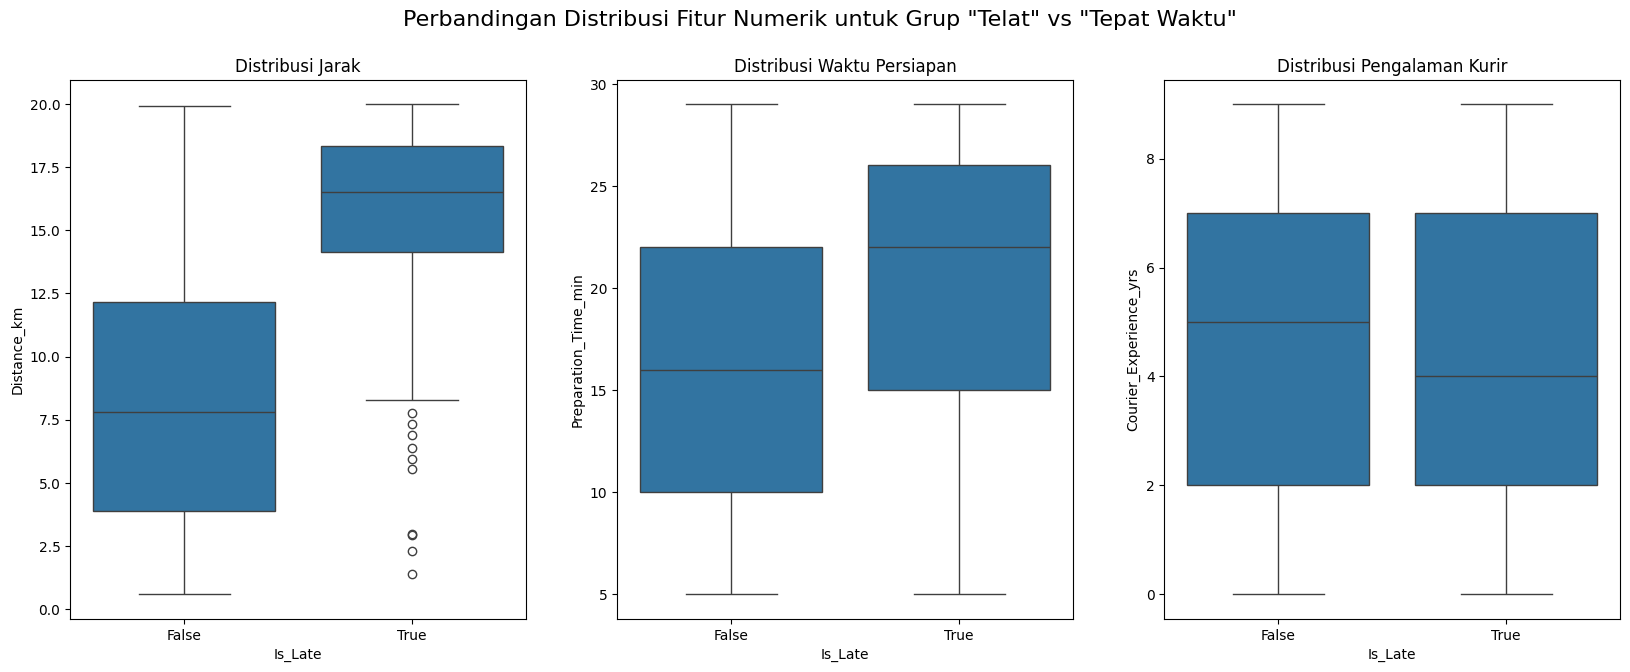

In [15]:
# Buat subplot untuk 3 fitur numerik
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Perbandingan Distribusi Fitur Numerik untuk Grup "Telat" vs "Tepat Waktu"', fontsize=16)

# Boxplot untuk Jarak
sns.boxplot(ax=axes[0], data=df_analysis, x='Is_Late', y='Distance_km')
axes[0].set_title('Distribusi Jarak')

# Boxplot untuk Waktu Persiapan
sns.boxplot(ax=axes[1], data=df_analysis, x='Is_Late', y='Preparation_Time_min')
axes[1].set_title('Distribusi Waktu Persiapan')

# Boxplot untuk Pengalaman Kurir
sns.boxplot(ax=axes[2], data=df_analysis, x='Is_Late', y='Courier_Experience_yrs')
axes[2].set_title('Distribusi Pengalaman Kurir')

plt.show()

**Insight:**
* Jarak adalah faktor paling dominan yang membedakan pengiriman telat dan tepat waktu. Seluruh kotak (Interquartile Range) untuk grup True berada di atas kotak untuk grup False. Artinya, 75% pengiriman yang telat memiliki jarak yang lebih jauh daripada 75% pengiriman yang tepat waktu.
* Waktu persiapan juga merupakan kontributor yang signifikan terhadap keterlambatan. Distribusi waktu persiapan untuk grup Telat (True) secara jelas lebih tinggi daripada grup Tepat Waktu (False).
* Kedua boxplot (untuk True dan False) terlihat hampir identik. Berdasarkan data ini, pengalaman kurir tampaknya tidak memiliki pengaruh yang signifikan terhadap status keterlambatan pengiriman.

In [16]:
# Lihat persentase keterlambatan per jenis kendaraan
print(df_analysis.groupby('Vehicle_Type')['Is_Late'].value_counts(normalize=True))

# Lihat persentase keterlambatan per kondisi lalu lintas
print(df_analysis.groupby('Traffic_Level')['Is_Late'].value_counts(normalize=True))

# Lihat persentase keterlambatan per cuaca
print(df_analysis.groupby('Weather')['Is_Late'].value_counts(normalize=True))

Vehicle_Type  Is_Late
Bike          False      0.755467
              True       0.244533
Car           False      0.758974
              True       0.241026
Scooter       False      0.784768
              True       0.215232
Name: proportion, dtype: float64
Traffic_Level  Is_Late
High           False      0.649746
               True       0.350254
Low            False      0.827676
               True       0.172324
Medium         False      0.764103
               True       0.235897
Name: proportion, dtype: float64
Weather  Is_Late
Clear    False      0.810638
         True       0.189362
Foggy    False      0.757282
         True       0.242718
Rainy    False      0.730392
         True       0.269608
Snowy    False      0.628866
         True       0.371134
Windy    False      0.750000
         True       0.250000
Name: proportion, dtype: float64


In [17]:
# Pivot table untuk melihat kombinasi Jenis Kendaraan dan Cuaca
pivot_table = pd.crosstab(index=df_analysis['Vehicle_Type'], columns=df_analysis['Weather'],
                          values=df_analysis['Is_Late'], aggfunc='mean')

styled_pivot = pivot_table.style.format('{:.1%}') \
                                .background_gradient(cmap='Reds')

styled_pivot

Weather,Clear,Foggy,Rainy,Snowy,Windy
Vehicle_Type,,,,,
Bike,20.9%,28.8%,26.5%,32.7%,26.4%
Car,20.8%,30.0%,20.5%,36.0%,25.0%
Scooter,14.9%,12.9%,32.3%,50.0%,21.7%


In [18]:
# Mempersiapkan Data (Mengubah dari Wide ke Long Format)
plot_data_weather = pivot_table.T.reset_index().melt(
    id_vars='Weather',
    var_name='Vehicle_Type',
    value_name='Probability_Late'
)
plot_data_weather.dropna(subset=['Probability_Late'], inplace=True)

print("Data yang sudah siap untuk di-plot (Weather):")
print(plot_data_weather.head())


Data yang sudah siap untuk di-plot (Weather):
  Weather Vehicle_Type  Probability_Late
0   Clear         Bike          0.209205
1   Foggy         Bike          0.288462
2   Rainy         Bike          0.265306
3   Snowy         Bike          0.326923
4   Windy         Bike          0.264151


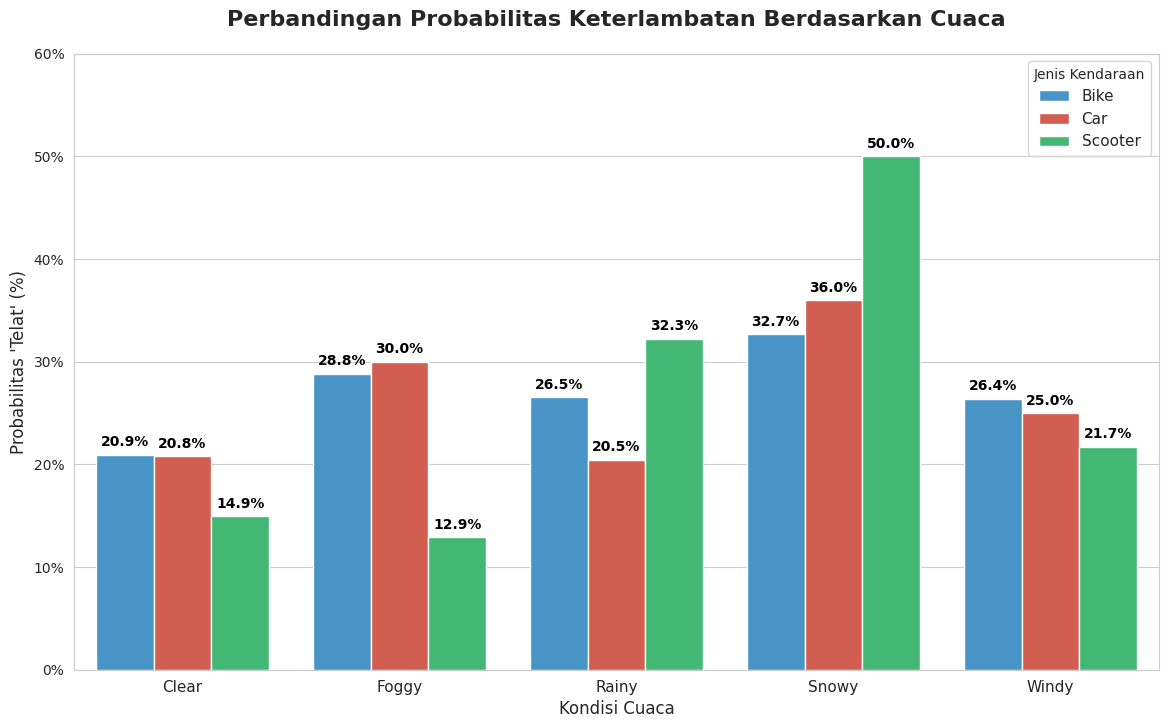

In [19]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=plot_data_weather,
    x='Weather',
    y='Probability_Late',
    hue='Vehicle_Type',
    palette={'Bike': '#3498db', 'Car': '#e74c3c', 'Scooter': '#2ecc71', 'Van': '#f1c40f'}
)

# Menambahkan kondisi 'if' untuk menghindari label pada bar dengan tinggi nol
for p in ax.patches:
    # HANYA tambahkan label jika tinggi bar (nilai probabilitas) > 0
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.1%}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=10, color='black', weight='bold')

# Kustomisasi plot
plt.title('Perbandingan Probabilitas Keterlambatan Berdasarkan Cuaca', fontsize=16, weight='bold', pad=20)
plt.xlabel('Kondisi Cuaca', fontsize=12)
plt.ylabel("Probabilitas 'Telat' (%)", fontsize=12)
plt.xticks(fontsize=11)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_ylim(top=plot_data_weather['Probability_Late'].max() * 1.2)
plt.legend(title='Jenis Kendaraan', fontsize=11)

plt.show()


**Insight:**
* Scooter adalah kendaraan paling efisien dan paling kecil kemungkinannya telat saat cuaca Clear (14.9%) dan Foggy (12.9%). Namun, situasinya berbalik drastis saat cuaca buruk. Scooter menjadi kendaraan paling berisiko dan paling mungkin telat saat Rainy (32.2%) dan terutama saat Snowy (50%). Probabilitas keterlambatan Skuter melonjak drastis di cuaca buruk.

* Car menunjukkan performa yang relatif baik saat Rainy (20.4%), bahkan lebih baik dari Bike. Ini masuk akal karena kurir lebih terlindungi.
Namun, saat Snowy, Car juga memiliki risiko keterlambatan yang sangat tinggi (36%).

In [20]:
# Pivot table untuk melihat kombinasi Jenis Kendaraan dan Traffic
pivot_table_traffic = pd.crosstab(
    index=df_analysis['Vehicle_Type'],
    columns=df_analysis['Traffic_Level'], # Kolom diubah menjadi Traffic_Level
    values=df_analysis['Is_Late'],
    aggfunc='mean'
)

styled_pivot_traffic = pivot_table_traffic.style.format('{:.1%}') \
                                            .background_gradient(cmap='Reds')

styled_pivot_traffic

Traffic_Level,High,Low,Medium
Vehicle_Type,,,
Bike,31.0%,20.1%,26.1%
Car,41.7%,17.2%,21.5%
Scooter,37.7%,11.8%,20.6%


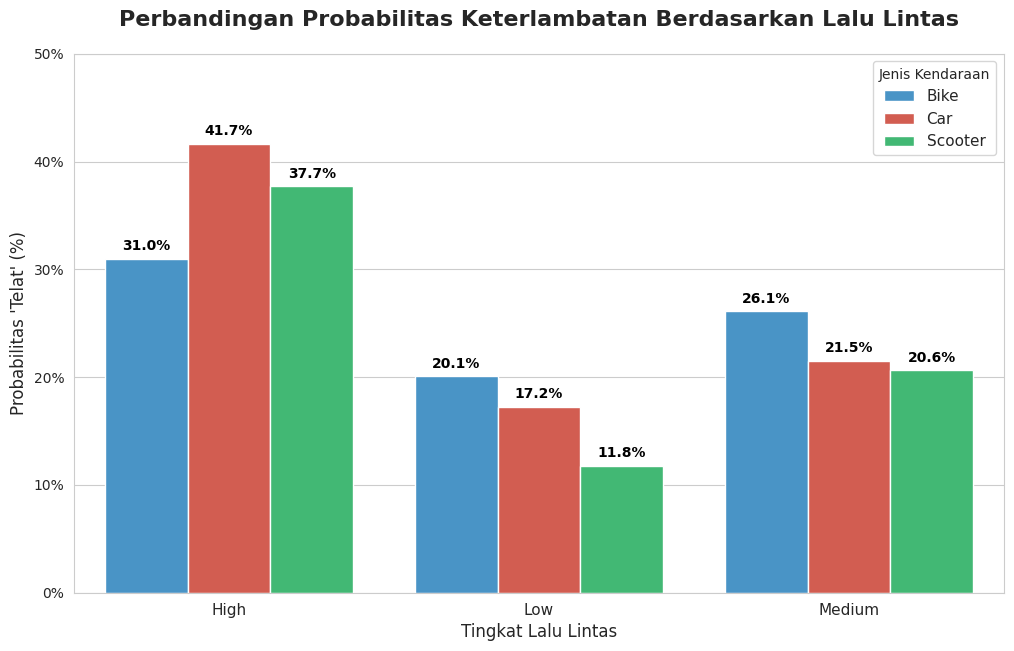

In [21]:
# Langkah 1: Mempersiapkan Data
plot_data_traffic = pivot_table_traffic.T.reset_index().melt(
    id_vars='Traffic_Level',
    var_name='Vehicle_Type',
    value_name='Probability_Late'
)

# Menghapus semua baris di mana 'Probability_Late' adalah NaN
plot_data_traffic.dropna(subset=['Probability_Late'], inplace=True)

# Langkah 2: Membuat Plot
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Membuat bar plot utama dari data yang sudah bersih
ax = sns.barplot(
    data=plot_data_traffic,
    x='Traffic_Level',
    y='Probability_Late',
    hue='Vehicle_Type',
    palette={'Bike': '#3498db', 'Car': '#e74c3c', 'Scooter': '#2ecc71'}
)

# Menambahkan label persentase di atas setiap bar
# dengan kondisi untuk menghindari label pada bar nol
for p in ax.patches:
    # HANYA tambahkan label jika tinggi bar (nilai probabilitas) > 0
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.1%}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontsize=10, color='black', weight='bold')

# Kustomisasi plot
plt.title('Perbandingan Probabilitas Keterlambatan Berdasarkan Lalu Lintas', fontsize=16, weight='bold', pad=20)
plt.xlabel('Tingkat Lalu Lintas', fontsize=12)
plt.ylabel("Probabilitas 'Telat' (%)", fontsize=12)
plt.xticks(fontsize=11)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_ylim(top=plot_data_traffic['Probability_Late'].max() * 1.2)
plt.legend(title='Jenis Kendaraan', fontsize=11)

plt.show()

**Insight:**
* Car memiliki probabilitas keterlambatan tertinggi (41.6%) saat lalu lintas High. Ini sangat logis karena mobil tidak bisa selincah kendaraan roda dua untuk bermanuver di tengah kemacetan.
* Meskipun semua kendaraan terpengaruh, Bike memiliki probabilitas keterlambatan paling rendah (31%) di antara ketiganya saat lalu lintas High. Ini menunjukkan kelincahan sepeda menjadi keuntungan utama di tengah kemacetan.
* Scooter menjadi kendaraan paling efisien dengan probabilitas keterlambatan terendah (11.7%) saat lalu lintas Low.

# Data Preprocessing

## Split Dataset

In [22]:
# Split Data
X = df.drop(['Order_ID', 'Delivery_Time_min'], axis=1, errors='ignore') # errors='ignore' jika kolom tidak selalu ada
y = df['Delivery_Time_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Buat salinan untuk menghindari SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()

**Notes:**
Mengingat dataset kita relatif kecil, yaitu 1000 baris, prioritas kami adalah memastikan bahwa evaluasi performa model dilakukan pada data uji yang cukup besar dan representatif yaitu data train : data tes = 75 : 25 agar memiliki hasil evaluasi yang lebih robust (kuat).

In [23]:
# Identifikasi Kolom Numerik dan Kategorikal
# Dilakukan pada X_train (sebelum diubah oleh pipeline)
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Kolom Numerik Mentah: {numerical_cols}")
print(f"Kolom Kategorikal Mentah: {categorical_cols}")

Kolom Numerik Mentah: ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']
Kolom Kategorikal Mentah: ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']


In [24]:
# Definisikan Pipeline Preprocessing untuk Setiap Tipe Kolom

# Pipeline untuk fitur numerikal
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Kita gunakan 'mean' untuk handling missing value numerikal
    ('scaler', StandardScaler())                # Kita gunakan StandarScaler untuk scaling data
])

# Pipeline untuk fitur kategorikal
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Kita gunakan 'mode' untuk handling missing value kategorikal
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Kita gunakan OHE untuk encoding data
])



**Insight:**
* Handing missing value numerikal menggunakan nilai rata-rata (mean), semenatara untuk kategorikal menggunakan mode (most_frequent). Kenapa missing value tidak kami drop? karena untuk menyelamatkan informasi berharga dan menghindari pengurangan ukuran dataset yang tidak perlu. Menghapus 30 baris berarti kita kehilangan 3% dari total data. Meskipun terdengar kecil, ini adalah kerugian yang tidak perlu.
* Scaling data menggunakan StandarScaler karena ketahanannya terhadap outlier. Kami memastikan bahwa outlier tidak secara tidak adil mendominasi skala data, sehingga model kami dapat belajar dari seluruh distribusi data secara lebih efektif. Ini adalah pilihan yang lebih aman dan lebih robust. Berbeda dengan MinMaxScaler, outlier tersebut akan 'menekan' sebagian besar data kami ke dalam rentang yang sangat sempit, sehingga menghilangkan informasi variasi yang berharga.
* Encoding menggunakan One-Hot-Encoding (OHE) karena untuk menghindari jebakan "urutan palsu" yang bisa diciptakan oleh LabelEncoder. Kami memastikan bahwa setiap kategori diperlakukan secara setara dan independen, sehingga model dapat mempelajari kontribusi masing-masing kategori terhadap waktu pengiriman tanpa bias atau asumsi urutan yang salah.

In [25]:
# Gabungkan Transformer Menggunakan ColumnTransformer
# ColumnTransformer akan menerapkan pipeline yang sesuai ke jenis kolom yang benar.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # 'passthrough' akan membiarkan kolom lain (jika ada dan tidak disebut) tidak diubah.
                            # Jika semua kolom sudah masuk numerical_cols atau categorical_cols, ini tidak banyak berpengaruh.
)


In [26]:
# Terapkan Preprocessor ke Data Training dan Testing

# Fit preprocessor pada X_train dan transform X_train
X_train_processed_array = preprocessor.fit_transform(X_train)

# Transform X_test menggunakan preprocessor yang sudah di-fit
X_test_processed_array = preprocessor.transform(X_test)

In [27]:
# Konversi Hasil Array ke DataFrame dengan Nama Kolom yang Benar

# Dapatkan nama fitur setelah transformasi (termasuk nama dari OneHotEncoder)
feature_names_out = preprocessor.get_feature_names_out()

# Buat DataFrame X_train_processed
X_train_processed = pd.DataFrame(X_train_processed_array, columns=feature_names_out, index=X_train.index)

# Buat DataFrame X_test_processed
X_test_processed = pd.DataFrame(X_test_processed_array, columns=feature_names_out, index=X_test.index)

print(f"\nDimensi X_train_processed setelah refactor: {X_train_processed.shape}")
print(f"Dimensi X_test_processed setelah refactor: {X_test_processed.shape}")


Dimensi X_train_processed setelah refactor: (750, 18)
Dimensi X_test_processed setelah refactor: (250, 18)


# Model Development & Evaluation

Dalam permodelan, kita akan melakukan uji performa pada model:
* Linear Regression (Baseline Model)

  Alasan Pemilihan: Model ini dipilih sebagai titik awal atau baseline karena kesederhanaannya, kemudahan interpretasi, dan efisiensi komputasi. Linear Regression membantu memahami hubungan linear dasar antara fitur-fitur dan variabel target (waktu pengiriman) serta memberikan standar performa untuk dibandingkan dengan model yang lebih kompleks.

* Random Forest

  Alasan Pemilihan: Random Forest adalah model ensemble learning yang kuat dan serbaguna. Model ini bekerja dengan membangun banyak pohon keputusan (decision trees) secara acak dan menggabungkan hasilnya. Keunggulannya meliputi kemampuannya menangani hubungan non-linear, interaksi antar fitur, mengurangi risiko overfitting dibandingkan satu pohon keputusan, serta memberikan informasi mengenai pentingnya setiap fitur (feature importance).

* XGBoost

  Alasan Pemilihan: XGBoost adalah implementasi algoritma gradient boosting yang sangat populer dan seringkali memberikan performa state-of-the-art pada berbagai masalah prediktif. XGBoost dikenal karena akurasi tinggi, kecepatan komputasi yang efisien (terutama melalui optimasi dan paralelisasi), serta kemampuannya dalam menangani data yang kompleks dan mencegah overfitting melalui teknik regularisasi bawaan.


Penjelasan Metrik Evaluasi yang digunakan:
* R2 Score (Koefisien Determinasi)

  R² mengukur seberapa baik variasi dalam variabel target (waktu pengiriman) dapat dijelaskan oleh fitur-fitur independen dalam model. Nilainya berkisar antara 0 hingga 1 (atau bisa negatif untuk model yang sangat buruk).

  **Semakin besar = semakin baik**

* MAE (Mean Absolute Error)

  MAE menghitung rata-rata dari selisih absolut (nilai mutlak) antara nilai aktual dan nilai prediksi yang dihasilkan oleh model.

  **Semakin kecil = semakin baik**

* RMSE (Root Mean Squared Error)

  RMSE adalah akar kuadrat dari rata-rata kuadrat selisih antara nilai aktual dan nilai prediksi. Seperti MAE, RMSE juga diukur dalam unit yang sama dengan variabel target.

  **Semakin kecil = semakin baik**

Kita akan fokus pada nilai RMSE karena dianggap sebagai metrik yang sangat penting karena sensitivitasnya terhadap kesalahan besar, yang berdampak signifikan pada kepuasan pelanggan. MAE juga dilaporkan karena memberikan interpretasi yang jelas tentang rata-rata kesalahan. Sementara R2 Score memberikan gambaran seberapa baik model menjelaskan variabilitas dalam waktu pengiriman.

----------------------------------------------------------------------------

Penjelasan tambahan:
* Overfitting: Kondisi dimana ketika model memiliki performa sangat baik pada data latih (data train) tetapi buruk pada data baru (data test).

## Using Default Parameters

In [30]:
print("\n## Model Development & Evaluation (Default Parameters) ##")

# Inisialisasi model-model yang akan digunakan
models_to_train = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "XGBoost Regressor": xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
}

# Dictionary untuk menyimpan model yang sudah dilatih
trained_models = {}
# List untuk menampung hasil evaluasi
results_list = []

for model_name, model_instance in models_to_train.items():
    print(f"\n--- Melatih Model: {model_name} (Default) ---")
    # Melatih model
    model_instance.fit(X_train_processed, y_train)
    # Menyimpan model yang sudah dilatih ke dalam dictionary
    trained_models[model_name] = model_instance
    print(f"Model {model_name} telah dilatih dan disimpan.")

    # Prediksi Train
    y_pred_train = model_instance.predict(X_train_processed)
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    # Prediksi Test
    y_pred_test = model_instance.predict(X_test_processed)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results_list.append({
        "Model": model_name,
        "R2 Train": r2_train, "MAE Train": mae_train, "RMSE Train": rmse_train,
        "R2 Test": r2_test, "MAE Test": mae_test, "RMSE Test": rmse_test
    })
    print(f"  R2 (Train): {r2_train:.3f} | R2 (Test): {r2_test:.3f}")
    print(f"  MAE (Train): {mae_train:.3f} | MAE (Test): {mae_test:.3f}")
    print(f"  RMSE (Train): {rmse_train:.3f} | RMSE (Test): {rmse_test:.3f}")

results_df = pd.DataFrame(results_list)
print("\n### Perbandingan Performa Model (Default Parameters) ###")
print(results_df.to_string())
print("-" * 70)



## Model Development & Evaluation (Default Parameters) ##

--- Melatih Model: Linear Regression (Default) ---
Model Linear Regression telah dilatih dan disimpan.
  R2 (Train): 0.754 | R2 (Test): 0.834
  MAE (Train): 6.669 | MAE (Test): 5.986
  RMSE (Train): 10.896 | RMSE (Test): 9.065

--- Melatih Model: Random Forest Regressor (Default) ---
Model Random Forest Regressor telah dilatih dan disimpan.
  R2 (Train): 0.956 | R2 (Test): 0.810
  MAE (Train): 2.999 | MAE (Test): 6.590
  RMSE (Train): 4.597 | RMSE (Test): 9.700

--- Melatih Model: XGBoost Regressor (Default) ---
Model XGBoost Regressor telah dilatih dan disimpan.
  R2 (Train): 0.999 | R2 (Test): 0.776
  MAE (Train): 0.394 | MAE (Test): 7.368
  RMSE (Train): 0.559 | RMSE (Test): 10.520

### Perbandingan Performa Model (Default Parameters) ###
                     Model  R2 Train  MAE Train  RMSE Train   R2 Test  MAE Test  RMSE Test
0        Linear Regression  0.754386   6.668631   10.895532  0.833670  5.986025   9.064704
1  Ran

**Insight:** Hasil dari evaluasi model dengan menggunakan default parameter menunjukan bahwa Linear Regression memiliki performa yang paling baik. Hal ini berdasarkan R2 Score pada data test, Linear Regression (0.834) menunjukkan performa generalisasi terbaik di antara ketiga model dengan parameter default. Model ini juga memiliki MAE (5.987) dan RMSE (9.065) terendah pada data test.

Indikasi Overfitting pada model:

* Random Forest Regressor menunjukkan tanda-tanda overfitting yang cukup jelas.
* XGBoost Regressor menunjukkan overfitting yang paling parah.

Namun Model yang lebih kompleks seperti Random Forest atau XGBoost mungkin belum optimal tanpa tuning. Oleh karena itu selanjutnya kita akan melakukan Hyperparameter Tuning pada kedua model ini agar mendapatkan hasil yang lebih optimal.


## Using Hyperparameter Tuning

In [31]:
## Model Linear Regression
results_tuned_list = []
lr_default_results = results_df[results_df['Model'] == 'Linear Regression'].iloc[0].to_dict() # Ganti nama di sini
results_tuned_list.append(lr_default_results)
print(f"Menggunakan hasil Linear Regression (Default): R2 Test={lr_default_results['R2 Test']:.3f}, RMSE Test={lr_default_results['RMSE Test']:.3f}")

Menggunakan hasil Linear Regression (Default): R2 Test=0.834, RMSE Test=9.065


### Random Forest Tuning & Evaluation

In [32]:
# Random Forest Tuning
print("\n--- Melakukan Hyperparameter Tuning untuk Random Forest Regressor ---")
rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100], # Jumlah pohon
    'max_depth': [None, 10],     # Kedalaman maksimum pohon
    'min_samples_split': [2, 4]  # Jumlah sampel minimum untuk split node
}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                              cv=5,
                              scoring='neg_root_mean_squared_error', # Optimalkan RMSE
                              verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train_processed, y_train)

print(f"Parameter terbaik Random Forest: {grid_search_rf.best_params_}")
best_rf_tuned = grid_search_rf.best_estimator_




--- Melakukan Hyperparameter Tuning untuk Random Forest Regressor ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Parameter terbaik Random Forest: {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 100}


In [33]:
# Evaluasi Random Forest Tuned
y_pred_train_rf_tuned = best_rf_tuned.predict(X_train_processed)
r2_train_rf = r2_score(y_train, y_pred_train_rf_tuned)
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf_tuned)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf_tuned))

y_pred_test_rf_tuned = best_rf_tuned.predict(X_test_processed)
r2_test_rf = r2_score(y_test, y_pred_test_rf_tuned)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf_tuned)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf_tuned))

results_tuned_list.append({
    "Model": "Random Forest (Tuned)",
    "R2 Train": r2_train_rf, "MAE Train": mae_train_rf, "RMSE Train": rmse_train_rf,
    "R2 Test": r2_test_rf, "MAE Test": mae_test_rf, "RMSE Test": rmse_test_rf
})
print(f"Random Forest (Tuned) - R2 (Train): {r2_train_rf:.3f} | R2 (Test): {r2_test_rf:.3f}")
print(f"Random Forest (Tuned) - MAE (Train): {mae_train_rf:.3f} | MAE (Test): {mae_test_rf:.3f}")
print(f"Random Forest (Tuned) - RMSE (Train): {rmse_train_rf:.3f} | RMSE (Test): {rmse_test_rf:.3f}")

Random Forest (Tuned) - R2 (Train): 0.936 | R2 (Test): 0.810
Random Forest (Tuned) - MAE (Train): 3.490 | MAE (Test): 6.561
Random Forest (Tuned) - RMSE (Train): 5.562 | RMSE (Test): 9.700


### XGBoost Tuning & Evaluation

In [34]:
# XGBoost Tuning
print("\n--- Melakukan Hyperparameter Tuning untuk XGBoost Regressor ---")
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

param_grid_xgb = {
    'n_estimators': [100, 200],               # [Default: 100]
    'learning_rate': [0.05, 0.1, 0.2],        # [Default: 0.3, tapi 0.1 sering jadi titik awal yg baik]
    'max_depth': [3, 5, 7],                   # [Default: 6 atau 3 tergantung versi] Kedalaman umum untuk XGBoost.
    'subsample': [0.8, 1.0],                  # [Default: 1.0] Fraksi sampel.
    'colsample_bytree': [0.8, 1.0],            # [Default: 1.0] Fraksi fitur.
    # Anda bisa tambahkan gamma, reg_alpha, reg_lambda jika iterasi awal ini cepat
    'gamma': [0, 0.1],
    'reg_lambda': [1, 1.5] # L2 regularization
}
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                               cv=5,
                               scoring='neg_root_mean_squared_error',
                               verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train_processed, y_train)

print(f"Parameter terbaik XGBoost: {grid_search_xgb.best_params_}")
best_xgb_tuned = grid_search_xgb.best_estimator_


--- Melakukan Hyperparameter Tuning untuk XGBoost Regressor ---
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Parameter terbaik XGBoost: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 1.5, 'subsample': 1.0}


In [35]:
# Evaluasi XGBoost Tuned
y_pred_train_xgb_tuned = best_xgb_tuned.predict(X_train_processed)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb_tuned)
mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb_tuned)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb_tuned))

y_pred_test_xgb_tuned = best_xgb_tuned.predict(X_test_processed)
r2_test_xgb = r2_score(y_test, y_pred_test_xgb_tuned)
mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb_tuned)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb_tuned))

results_tuned_list.append({
    "Model": "XGBoost (Tuned)",
    "R2 Train": r2_train_xgb, "MAE Train": mae_train_xgb, "RMSE Train": rmse_train_xgb,
    "R2 Test": r2_test_xgb, "MAE Test": mae_test_xgb, "RMSE Test": rmse_test_xgb
})
print(f"XGBoost (Tuned) - R2 (Train): {r2_train_xgb:.3f} | R2 (Test): {r2_test_xgb:.3f}")
print(f"XGBoost (Tuned) - MAE (Train): {mae_train_xgb:.3f} | MAE (Test): {mae_test_xgb:.3f}")
print(f"XGBoost (Tuned) - RMSE (Train): {rmse_train_xgb:.3f} | RMSE (Test): {rmse_test_xgb:.3f}")

XGBoost (Tuned) - R2 (Train): 0.828 | R2 (Test): 0.822
XGBoost (Tuned) - MAE (Train): 5.717 | MAE (Test): 6.174
XGBoost (Tuned) - RMSE (Train): 9.119 | RMSE (Test): 9.373


**Insight:** Untuk Hyperparameter Tuning pada Random Forest dan XGBoost.

Kita melakukan tuning ini untuk secara sistematis melawan overfitting yang kita lihat pada model default dan untuk mencari kombinasi parameter yang membuat model tidak hanya hebat pada data latihan, tetapi juga bisa digeneralisasi dengan baik pada data baru.

Alasan utama mengapa performanya masih kalah kemungkinan besar bukan karena tuning grid yang kurang luas, tetapi karena karakteristik fundamental dari data kita.

Tuning dapat mengoptimalkan sebuah model, tetapi tidak dapat mengubah sifat dasarnya. Jika data bersifat linear, model linear akan tetap menjadi pilihan yang paling alami dan efisien. Usaha tuning pada model yang lebih kompleks justru membuktikan bahwa bahkan setelah model dioptimalkan, mereka tidak bisa mengalahkan model yang lebih sederhana namun lebih tepat untuk masalahnya.



## Conclusion Model Evaluation

In [36]:
# Gabungkan hasil default RF dan XGB untuk perbandingan lengkap
rf_default_results = results_df[results_df['Model'] == 'Random Forest Regressor'].iloc[0].to_dict()
rf_default_results['Model'] = 'Random Forest (Default)' # Ubah nama untuk kejelasan
xgb_default_results = results_df[results_df['Model'] == 'XGBoost Regressor'].iloc[0].to_dict()
xgb_default_results['Model'] = 'XGBoost (Default)' # Ubah nama

# Buat DataFrame baru untuk perbandingan akhir
comparison_df_list = [lr_default_results, rf_default_results, results_tuned_list[1], xgb_default_results, results_tuned_list[2]]
final_comparison_df = pd.DataFrame(comparison_df_list)

print("\n### Perbandingan Performa Model Akhir (Default vs Tuned) ###")
print(final_comparison_df.sort_values(by='RMSE Test').to_string())
print("-" * 70)


### Perbandingan Performa Model Akhir (Default vs Tuned) ###
                     Model  R2 Train  MAE Train  RMSE Train   R2 Test  MAE Test  RMSE Test
0        Linear Regression  0.754386   6.668631   10.895532  0.833670  5.986025   9.064704
4          XGBoost (Tuned)  0.827944   5.716526    9.119191  0.822148  6.174429   9.373400
1  Random Forest (Default)  0.956271   2.998707    4.597316  0.809550  6.590440   9.699702
2    Random Forest (Tuned)  0.935996   3.490490    5.561921  0.809540  6.560937   9.699973
3        XGBoost (Default)  0.999354   0.393835    0.558761  0.775972  7.368124  10.520086
----------------------------------------------------------------------


**Insight:**

Setelah melakukan evaluasi terhadap beberapa model, Linear Regression terpilih sebagai model terbaik untuk memprediksi waktu pengiriman makanan dalam proyek ini.

1. **R² (R-squared)** : Semakin Besar = Semakin Baik

    Linear Regression mendapatkan skor R² 0.834 pada data tes. Ini berarti model Linear Regression mampu menjelaskan sekitar 83.4% variasi dalam waktu pengiriman. Ini adalah skor R² tertinggi dibandingkan model lainnya saat diuji pada data baru (data tes), menunjukkan pemahaman terbaik terhadap pola data.

2. **MAE (Mean Absolute Error)** : Semakin Kecil = Semakin Baik

    Linear Regression memiliki MAE sebesar 5.99 menit pada data tes. Artinya, secara rata-rata, prediksi waktu pengiriman dari model ini hanya meleset sekitar 6 menit dari kenyataan. Ini adalah angka 'meleset' terkecil dibandingkan model-model lainnya.

3. **RMSE (Root Mean Squared Error)** : Semakin Kecil = Semakin Baik

    Linear Regression mencatatkan RMSE sebesar 9.06 menit pada data tes. Ini juga merupakan nilai RMSE terendah di antara semua model. Ini menandakan bahwa Linear Regression tidak hanya akurat secara rata-rata, tetapi juga paling jarang membuat kesalahan prediksi yang sangat besar.

**Conclusion:**

Dari semua metode yang kami coba untuk memprediksi waktu pengiriman, model Linear Regression terbukti menjadi yang paling akurat dan memiliki performa yang paling baik. Model ini paling 'paham' faktor-faktor yang mempengaruhi durasi pengiriman (R² tertinggi), rata-rata tebakannya paling dekat dengan kenyataan (MAE terendah), dan paling jarang membuat kesalahan prediksi yang fatal (RMSE terendah) ketika diuji pada data baru.

Linear Regression adalah model yang dirancang khusus untuk menangkap hubungan linear. Kemungkinan besar data memiliki hubungan yang sangat dominan dan linear antara fitur (terutama Distance_km) dan target (Delivery_Time_min). Jika hubungan utamanya memang lurus, model yang lebih kompleks seperti Random Forest bisa jadi "terlalu pintar" dan mencoba menemukan pola non-linear yang sebenarnya hanyalah noise (gangguan acak), yang justru membuat performanya di data test menjadi lebih buruk. Ini adalah prinsip Occam's Razor: model paling sederhana yang mampu menjelaskan data dengan baik seringkali adalah yang terbaik.

# Visualisasi Performa Model


--- Membuat Visualisasi Actual vs. Predicted untuk: Linear Regression ---


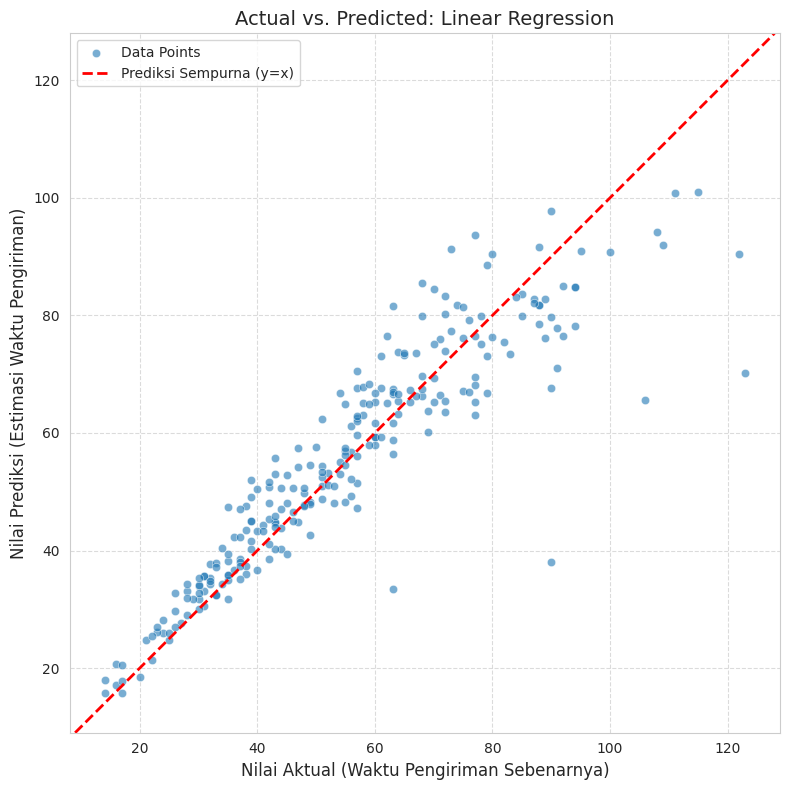

In [37]:
# --- Visualisasi untuk Model Terbaik (Linear Regression) ---
best_model_name_to_plot = "Linear Regression" # Ganti dengan nama model terbaik Anda
model_for_plot = trained_models.get(best_model_name_to_plot)

if model_for_plot is not None and 'y_test' in locals() and 'X_test_processed' in locals():
    print(f"\n--- Membuat Visualisasi Actual vs. Predicted untuk: {best_model_name_to_plot} ---")
    y_pred_plot = model_for_plot.predict(X_test_processed)

    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred_plot, alpha=0.6, edgecolors='w', linewidth=0.5, label='Data Points')

    min_val = min(np.min(y_test), np.min(y_pred_plot)) - 5
    max_val = max(np.max(y_test), np.max(y_pred_plot)) + 5
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prediksi Sempurna (y=x)')

    plt.xlabel("Nilai Aktual (Waktu Pengiriman Sebenarnya)", fontsize=12)
    plt.ylabel("Nilai Prediksi (Estimasi Waktu Pengiriman)", fontsize=12)
    plt.title(f"Actual vs. Predicted: {best_model_name_to_plot}", fontsize=14)
    plt.axis('equal')
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

else:
    if model_for_plot is None:
        print(f"Model '{best_model_name_to_plot}' tidak ditemukan untuk visualisasi.")
    else:
        print("Variabel 'y_test' atau 'X_test_processed' belum didefinisikan. Pastikan data test sudah siap.")

**Insight:**

* **Tren Umum Positif:** Secara keseluruhan, model Anda berhasil menangkap tren utama data. Titik-titik data (prediksi) cenderung mengikuti arah garis merah "Prediksi Sempurna" (y=x), yang berarti ada korelasi positif antara nilai aktual dan nilai prediksi waktu pengiriman.

* **Adanya Error Prediksi:** Meskipun trennya positif, titik-titik tidak jatuh tepat di garis merah. Sebaran titik di sekitar garis menunjukkan bahwa model tidak selalu memprediksi dengan sempurna dan ada selisih (error) antara prediksi dan kenyataan.

* **Variabilitas pada Nilai Tinggi:** Untuk waktu pengiriman yang lebih lama (nilai aktual yang lebih tinggi, misalnya di atas 80-90 menit), sebaran titik tampak sedikit lebih lebar. Ini mengindikasikan bahwa prediksi model untuk durasi pengiriman yang panjang mungkin memiliki variasi error yang lebih besar. Terlihat ada beberapa kasus di mana model cenderung under-predict (memprediksi waktu lebih cepat dari kenyataannya) untuk pengiriman yang sangat lama.
    
* **Identifikasi Prediksi Kurang Akurat:** Ada beberapa titik data individual yang posisinya cukup jauh dari garis diagonal. Ini adalah contoh-contoh spesifik di mana prediksi model cukup meleset dari nilai aktualnya.

Secara Sederhana:
Model cukup baik dalam mengikuti pola umum waktu pengiriman, tetapi belum sempurna. Ada kesalahan dalam prediksi, dan tampaknya model sedikit lebih kesulitan (atau errornya lebih bervariasi) ketika memprediksi waktu pengiriman yang sangat lama.

# Feature Importance

In [38]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [39]:
# Memastikan 'trained_models' sudah ada di blok kode di atas
if 'trained_models' in locals() and "Linear Regression" in trained_models:
    linear_model_final = trained_models["Linear Regression"]
    print(f"\nModel Linear Regression berhasil diakses dari trained_models.")
else:
    print("\nError: 'trained_models' tidak ditemukan atau model 'Linear Regression' tidak ada di dalamnya.")
    linear_model_final = None # Atur ke None jika tidak ditemukan agar pengecekan selanjutnya tidak error


Model Linear Regression berhasil diakses dari trained_models.


In [41]:
if linear_model_final is not None: # Memastikan model berhasil diambil
    if hasattr(linear_model_final, 'coef_'):
        print("\nFeature Importance dari Linear Regression (Model Tersimpan):")

        # Mendapatkan koefisien
        coefficients = linear_model_final.coef_

        # Mendapatkan nama fitur
        if isinstance(X_train_processed, pd.DataFrame):
            feature_names = X_train_processed.columns
        else:
            # Fallback jika X_train_processed bukan DataFrame (kurang ideal)
            feature_names = [f'feature_{i}' for i in range(coefficients.shape[0])]
            print("Peringatan: X_train_processed bukan DataFrame Pandas, nama fitur generik digunakan.")

        # Membuat DataFrame untuk feature importance
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
        feature_importance_df['Importance (Abs_Coefficient)'] = np.abs(feature_importance_df['Coefficient'])

        # Mengurutkan berdasarkan nilai absolut koefisien (Importance)
        feature_importance_df = feature_importance_df.sort_values(by='Importance (Abs_Coefficient)', ascending=False)

        print("\nTop 10 Features berdasarkan Besarnya Koefisien (Absolut):")
        print(feature_importance_df.head(10).to_string()) # .to_string() untuk tampilan rapi



Feature Importance dari Linear Regression (Model Tersimpan):

Top 10 Features berdasarkan Besarnya Koefisien (Absolut):
                        Feature  Coefficient  Importance (Abs_Coefficient)
0              num__Distance_km    16.791830                     16.791830
1     num__Preparation_Time_min     7.053264                      7.053264
8       cat__Traffic_Level_High     5.589407                      5.589407
9        cat__Traffic_Level_Low    -5.552804                      5.552804
6            cat__Weather_Snowy     4.891834                      4.891834
3            cat__Weather_Clear    -4.320429                      4.320429
7            cat__Weather_Windy    -2.881280                      2.881280
2   num__Courier_Experience_yrs    -1.975889                      1.975889
4            cat__Weather_Foggy     1.678105                      1.678105
14       cat__Time_of_Day_Night    -1.189798                      1.189798


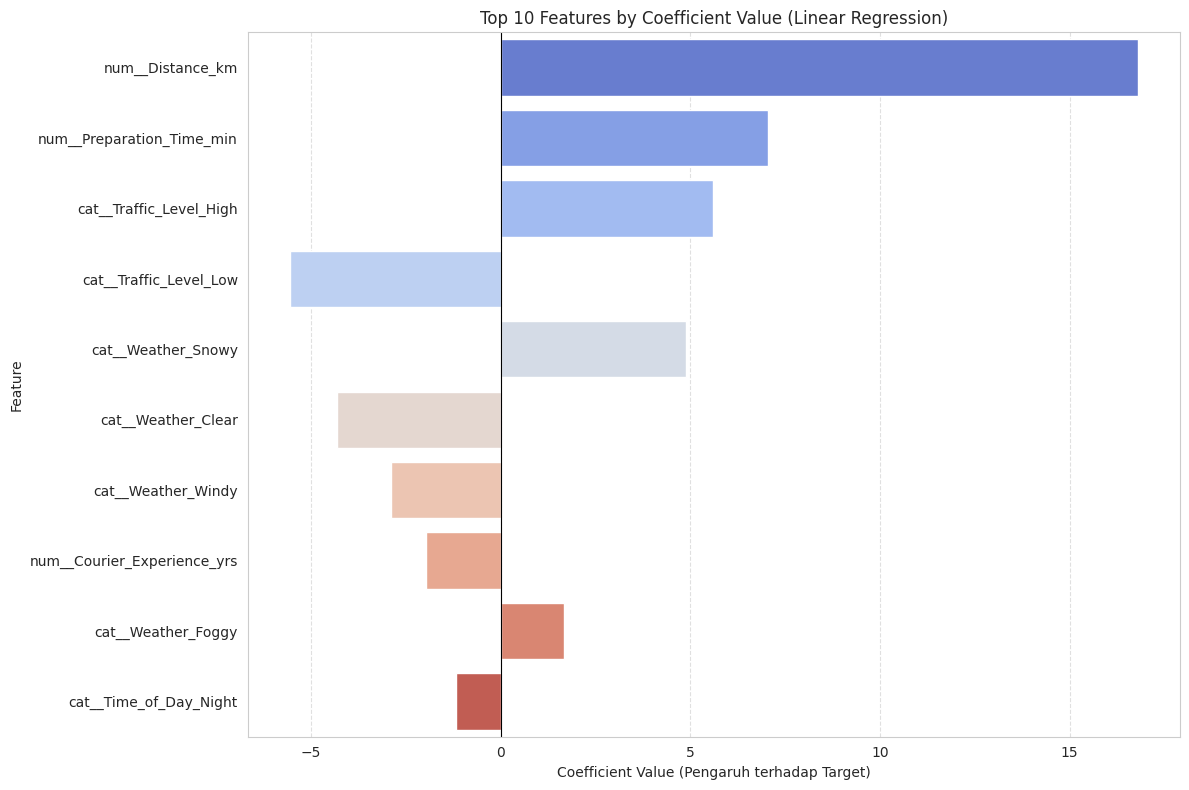


CATATAN PENTING:
1. 'Importance' untuk Linear Regression diinterpretasikan dari besarnya (magnitudo) koefisien.
2. Tanda koefisien (+ atau -) menunjukkan arah hubungan dengan variabel target.
3. Untuk perbandingan 'importance' yang lebih adil antar fitur, fitur-fitur numerik
   dalam X_train_processed telah di-scaling sebelum melatih model.


In [42]:
# Visualisasi Top 10 Feature Importances
top_n_features = 10
df_coef_top = feature_importance_df.head(top_n_features)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=df_coef_top, palette='coolwarm')
plt.title(f'Top {top_n_features} Features by Coefficient Value (Linear Regression)')
plt.xlabel('Coefficient Value (Pengaruh terhadap Target)')
plt.ylabel('Feature')
plt.axvline(0, color='black', lw=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nCATATAN PENTING:")
print("1. 'Importance' untuk Linear Regression diinterpretasikan dari besarnya (magnitudo) koefisien.")
print("2. Tanda koefisien (+ atau -) menunjukkan arah hubungan dengan variabel target.")
print("3. Untuk perbandingan 'importance' yang lebih adil antar fitur, fitur-fitur numerik")
print("   dalam X_train_processed telah di-scaling sebelum melatih model.")

**Insight:**

Faktor-faktor yang MEMPERLAMBAT Waktu Pengiriman (Koefisien Positif +):

* Jarak Pengiriman (Distance_km): Faktor paling dominan yang memperlama.
* Waktu Persiapan (Preparation_Time_min): Semakin lama persiapan, semakin lama pengiriman.
* Lalu Lintas Tinggi (Traffic_Level_High): Kemacetan jelas memperlambat.
* Cuaca Bersalju (Weather_Snowy): Salju sangat menghambat.
* Cuaca Berkabut (Weather_Foggy): Kabut juga menambah waktu tempuh.

Faktor-faktor yang MEMPERCEPAT Waktu Pengiriman (Koefisien Negatif -):

* Lalu Lintas Rendah (Traffic_Level_Low): Sangat membantu mempercepat.
* Cuaca Cerah (Weather_Clear): Kondisi ideal untuk pengiriman lebih cepat.
* Cuaca Berangin (Weather_Windy): Menariknya, model Anda menunjukkan ini mempercepat.
* Pengalaman Kurir (Courier_Experience_yrs): Kurir berpengalaman lebih efisien.
* Waktu Malam (Time_of_Day_Night): Pengiriman di malam hari cenderung lebih cepat.

Model menunjukkan bahwa jarak dan waktu persiapan adalah dua prediktor terkuat yang memperlama pengiriman. Kondisi lalu lintas dan cuaca juga memiliki pengaruh besar, dengan efek yang logis (macet/cuaca buruk memperlama, lancar/cuaca baik mempercepat). Pengalaman kurir dan pengiriman malam hari memberikan kontribusi positif dalam mengurangi waktu tempuh.

# Conclusion & Recomendation

**Kesimpulan:**

**Performa Model Terbaik:** Dari model-model yang dievaluasi (Linear Regression, Random Forest, XGBoost), Linear Regression secara konsisten menunjukkan performa terbaik dan paling robust pada data uji (Test RMSE terendah sekitar 9.06 menit). Meskipun model yang lebih kompleks seperti XGBoost menunjukkan potensi setelah tuning ekstensif (Test RMSE ~9.40 menit), Linear Regression dengan parameter defaultnya sudah memberikan hasil yang sangat kompetitif dan lebih sederhana untuk diinterpretasikan dalam kasus ini.

**Faktor Paling Berpengaruh** (Feature Importance dari Linear Regression):

Faktor yang signifikan memperlama waktu pengiriman adalah:
  - Distance_km (Jarak Pengiriman): Pengaruh paling dominan.
  - Preparation_Time_min (Waktu Persiapan Pesanan).
  - Traffic_Level_High (Kondisi Lalu Lintas Macet).
  - Weather_Snowy (Cuaca Bersalju).

Faktor yang signifikan mempercepat waktu pengiriman adalah:
  - Traffic_Level_Low (Kondisi Lalu Lintas Lancar).
  - Weather_Clear (Cuaca Cerah).
  - Courier_Experience_yrs (Pengalaman Kurir).
  - Time_of_Day_Night (Pengiriman Malam Hari).

**Validitas Logika Bisnis:** Sebagian besar faktor yang teridentifikasi memiliki pengaruh yang sejalan dengan intuisi dan logika bisnis umum dalam industri pengiriman makanan. Jarak yang lebih jauh, waktu persiapan yang lama, lalu lintas padat, dan cuaca buruk secara alami akan memperpanjang waktu pengiriman. Sebaliknya, lalu lintas lancar, cuaca baik, kurir berpengalaman, dan kondisi malam hari (kemungkinan lalu lintas lebih sepi) membantu mempercepat proses.



**Rekomendasi:**

* **Optimalkan Jarak & Rute:** Prioritaskan pengurangan Distance_km melalui zoning dan dispatch yang lebih baik. Integrasikan data lalu lintas real-time untuk estimasi dan pemilihan rute yang akurat.

* **Percepat Waktu Persiapan:** Dorong efisiensi Preparation_Time_min melalui kerjasama dengan restoran mitra.

* **Manfaatkan SDM & Waktu:**  Tingkatkan keahlian kurir (Courier_Experience_yrs) dan pertimbangkan strategi untuk memaksimalkan efisiensi pada Time_of_Day_Night atau saat Traffic_Level_Low.

* **Implementasi & Iterasi Model:** Gunakan model Linear Regression untuk estimasi waktu pengiriman (ETA). Lakukan monitoring, retraining berkala, dan pertimbangkan penambahan fitur untuk peningkatan di masa depan.

* **Adaptasi Kondisi Eksternal:** Sesuaikan operasional dan ekspektasi ETA berdasarkan kondisi cuaca signifikan (misalnya, Weather_Snowy, Weather_Clear).

# Deployment

In [43]:
# Karena model terbaik adalah Linear Regression dengan parameter default:
best_model = LinearRegression()

# Buat Pipeline Lengkap dengan Preprocessor dan Model Terbaik
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model) # Menggunakan Linear Regression
])

# Latih Seluruh Pipeline
# X_train di sini adalah DataFrame mentah (sebelum preprocessing manual),
# y_train adalah target.
full_pipeline.fit(X_train, y_train)
print("Pipeline lengkap dengan Linear Regression telah dilatih.")

# Simpan Pipeline Lengkap
joblib.dump(full_pipeline, 'linear_regression_pipeline.pkl') # Nama file disesuaikan
print("Pipeline lengkap (Linear Regression) berhasil disimpan sebagai linear_regression_pipeline.pkl")

Pipeline lengkap dengan Linear Regression telah dilatih.
Pipeline lengkap (Linear Regression) berhasil disimpan sebagai linear_regression_pipeline.pkl
